In [1]:
import os
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Global variables

In [2]:
DIR_TFRECORDS = 'data_small_tfrecords'
DATA_TRAIN = glob('./'+DIR_TFRECORDS+'/*.tfrecords')

NUM_OBJECTS = 20

GRID_SIZE = 32
GRID_H, GRID_W = 19, 19

ANCHORS_NORMALIZED = np.array(
    [
        [0.09112895, 0.06958421],
        [0.21102316, 0.16803947],
        [0.42625895, 0.26609842],
        [0.25476474, 0.49848   ],
        [0.52668947, 0.59138947]
    ]
)
ANCHORS = ANCHORS_NORMALIZED * np.array([GRID_H, GRID_W])
NUM_ANCHORS = ANCHORS.shape[0]

IMG_H, IMG_W = 608, 608  # GRID_H * GRID_SIZE = 19 * 32 = 608

COOEFFICIENT_OBJ = 1
COOEFFICIENT_NO_OBJ = .005
COOEFFICIENT_REG = 5

THRESHOLD_IOU = 0.5
SCALE_LOSS_CONFIDENCE_OBJECT_PRESENT = 5
THRESHOLD_OUT_PROB = 0.5
THRESHOLD_IOU_NMS = 0.5

NUM_EPOCHS = 10
BATCH_SIZE = 8
MODEL_DIR = 'model'

DEBUG = True

## Yolo Loss function

In [3]:
def get_mapped_output(output):
    anchors = tf.cast(tf.reshape(ANCHORS, [1, 1, 1, ANCHORS.shape[0], 2]), dtype=tf.float32)  # try using variable for ANCHORS
    
    # create cartesian grid on output space
    coordinates_y = tf.range(GRID_H)
    coordinates_x = tf.range(GRID_W)
    x, y = tf.meshgrid(coordinates_x, coordinates_y)
    x = tf.reshape(x, [-1])
    y = tf.reshape(y, [-1])
    coordinates = tf.stack([y, x], 1)
    coordinates = tf.reshape(coordinates, [1, GRID_H, GRID_W, 1, 2])
    coordinates = tf.cast(coordinates, tf.float32)
    
    # change dimensions of tensors for broadcasting
    output = tf.reshape(output, [-1, GRID_H, GRID_W, ANCHORS.shape[0], 5+NUM_OBJECTS])
    shape = tf.cast(tf.reshape(tf.shape(output)[1:3], [1, 1, 1, 1, 2]), tf.float32)
    
    # map output to input space (also split yx, hw, prob_obj, prob_class)
    out_yx = tf.sigmoid(output[..., :2])  # sigmoid to keep centers in interval [0,1]
    out_hw = tf.exp(output[..., 2:4])  # exp to keep values positive
    out_yx = (out_yx + coordinates) / shape  # maps values to [0,1] input image space
    out_hw = out_hw * anchors / shape
    
    # get corresponding probabilities
    out_prob_obj = tf.sigmoid(output[..., 4:5])
    out_prob_class = tf.nn.softmax(output[..., 5:])
    
    return out_yx, out_hw, out_prob_obj, out_prob_class
    

def get_iou(out_yx, out_hw, targets):
    # out_yx.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 2]
    # targets.shape = [BATCH_SIZE, MAX_OBJECTS, 5]
    
    # compute ious for each anchor in each grid in axis=4
    out_yx = tf.expand_dims(out_yx, 4)
    out_hw = tf.expand_dims(out_hw, 4)
    out_min = out_yx - out_hw/2.
    out_max = out_yx + out_hw/2.
    
    targets = tf.reshape(targets, [tf.shape(targets)[0], 1, 1, 1, MAX_OBJECTS, 5])
    targets_yx = targets[..., 0:2]
    targets_hw = targets[..., 2:4]
    
    targets_min = targets_yx - targets_hw/2.
    targets_max = targets_yx + targets_hw/2.
    
    intersection_min = tf.maximum(out_min, targets_min)
    intersection_max = tf.minimum(out_max, targets_max)
    intersection_hw = tf.maximum(intersection_max - intersection_min, 0.)
    area_intersection = intersection_hw[..., 0] * intersection_hw[..., 1]
    
    area_out = out_hw[...,0] * out_hw[...,1]
    area_targets = targets[...,0] * targets[...,1]
    area_union = area_targets + area_out - area_intersection
    iou = area_intersection / area_union
    
    return iou
    

def get_confidence_loss(out_flag_object, flag_object, out_prob_obj):
    mask_object_absent = (1 - out_flag_object) * (1 - flag_object)
    loss_object_absent = mask_object_absent * tf.square(out_prob_obj)
    
    loss_object_present = flag_object * tf.square(1-out_prob_obj)
    return loss_object_absent + SCALE_LOSS_CONFIDENCE_OBJECT_PRESENT*loss_object_present
    
def get_classification_loss(flag_object, box_adjustments, out_prob_class):
    classes = tf.cast(box_adjustments[...,4], tf.int32)
    classes = tf.one_hot(classes, NUM_OBJECTS)
    
    loss_classification = flag_object * tf.square(classes - out_prob_class)
    
    return loss_classification

def get_regression_loss(out_box_adjustments, flag_object, box_adjustments):
    loss_regression = flag_object * tf.square(box_adjustments[...,:4] - out_box_adjustments)
    
    return loss_regression
    
def get_loss(predictions, labels):
    # predictions.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+NUM_OBJECTS] (they are in grid space)
    # labels.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 6]

    # split labels 
    mask_object = tf.cast(tf.reshape(labels[...,5], [-1, GRID_H, GRID_W, NUM_ANCHORS]), tf.bool)
    labels_box = labels[...,0:5]
    
    # apply mask to differentiate object vs no_object areas
    labels_masked = tf.boolean_mask(labels_box, mask_object)
    predictions_masked = tf.boolean_mask(predictions, mask_object)
    predictions_masked_negative = tf.boolean_mask(predictions, tf.logical_not(mask_object))
    
    # apply corresponding transformations on predictions
    predictions_masked_yx = tf.sigmoid(predictions_masked[...,0:2])
    predictions_masked_hw = tf.exp(predictions_masked[...,2:4])
    predictions_masked_obj = tf.sigmoid(predictions_masked[...,4])
    predictions_masked_no_obj = tf.sigmoid(predictions_masked_negative[...,4])
    predictions_masked_class = tf.nn.softmax(predictions_masked[...,5:])
    
    # split labels_box
    labels_masked_yx = labels_masked[...,0:2]
    labels_masked_hw = labels_masked[...,2:4]
    labels_masked_class = labels_masked[...,4]
    labels_masked_one_hot = tf.reshape(tf.one_hot(tf.cast(labels_masked_class, tf.int32), NUM_OBJECTS), [-1, NUM_OBJECTS])
    
    # compute loss
    loss_object = tf.reduce_sum(tf.square(predictions_masked_obj - 1))
    loss_no_object = tf.reduce_sum(tf.square(predictions_masked_no_obj))
    loss_yx = tf.reduce_sum(tf.square(predictions_masked_yx - labels_masked_yx))
    loss_hw = tf.reduce_sum(tf.square(predictions_masked_hw - labels_masked_hw))
    loss_class = tf.reduce_sum(tf.square(predictions_masked_class - labels_masked_one_hot))
    
    loss = tf.cast(1/tf.shape(predictions)[0], tf.float32) * (COOEFFICIENT_OBJ*loss_object + COOEFFICIENT_NO_OBJ*loss_no_object + COOEFFICIENT_REG*(loss_yx + loss_hw) + loss_class)
    
#     # map output from grid space to [0,1] space
#     out_yx, out_hw, out_prob_obj, out_prob_class = get_mapped_output(output)
    
#     # get iou for all boxes wrt each anchor in each grid
#     iou = get_iou(out_yx, out_hw, targets)
    
#     # keep best bbox for each anchor for each grid as per iou
#     iou_best = tf.reduce_max(iou, axis=4, keepdims=True)
    
#     # threshold over ious
#     out_flag_object = tf.cast(iou_best > THRESHOLD_IOU, tf.float32)
    
#     # object presence loss (confidence)
#     loss_confidence = get_confidence_loss(out_flag_object, flag_object, out_prob_obj)
    
#     # classification loss
#     loss_classification = get_classification_loss(flag_object, box_adjustments, out_prob_class)
    
#     # regression loss
#     out_box_adjustments = tf.concat([tf.sigmoid(output[...,0:2]), tf.exp(output[...,2:4])], axis=-1)
#     loss_regression = get_regression_loss(out_box_adjustments, flag_object, box_adjustments)
    
#     # accumulate loss
#     loss_confidence_sum = tf.reduce_sum(loss_confidence)
#     loss_classification_sum = tf.reduce_sum(loss_classification)
#     loss_regression_sum = tf.reduce_sum(loss_regression)
    
#     loss = tf.cast(1/tf.shape(targets)[0], tf.float32) * 0.5 * (loss_confidence_sum + loss_classification_sum + loss_regression_sum)
    
    
    return loss

## Post-processing

In [4]:
def center2corner(out_yx, out_hw):
    # out_yx.shape = [GRID_H, GRID_W, NUM_ANCHORS, 2]
    
    box_min = out_yx - (out_hw/2.)
    box_max = out_yx + (out_hw/2.)
    
    out_corners = tf.concat([box_min[...,0:1], box_min[...,1:2], box_max[...,0:1], box_max[...,1:2]], axis=-1)
    return out_corners

def get_filtered_output(map_params):
    # this is done to use batch 
    out_corners, out_prob_obj, out_prob_class = map_params[0], map_params[1], map_params[2]
    
    # compute overall prob for each anchor in each grid
    out_prob = out_prob_obj * out_prob_class
    
    # get max prob among all classes at each anchor in each grid
    class_max = tf.argmax(out_prob, axis=-1)
    prob_class = tf.reduce_max(out_prob, axis=-1)
    
    # compute filter mask
    mask_filter = prob_class >= THRESHOLD_OUT_PROB
    
    # apply mask on output
    box_filtered = tf.boolean_mask(out_corners, mask_filter)
    prob_filtered = tf.boolean_mask(prob_class, mask_filter)
    class_filtered = tf.boolean_mask(class_max, mask_filter)
    return box_filtered, prob_filtered, class_filtered

def get_predictions(output):
    # output.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+20]
    
    # split output
    out_yx, out_hw, out_prob_obj, out_prob_class = get_mapped_output(output)
    
    # convert boxes from center coordinates to corner coordinates
    out_corners = center2corner(out_yx, out_hw)
    
    # filter output (needs to be done separately for each image in batch)
    box_filtered, prob_filtered, class_filtered = tf.map_fn(
        get_filtered_output, 
        (out_corners, out_prob_obj, out_prob_class),
        dtype=(tf.float32, tf.float32, tf.int64)
    )
    
    # scale boxes from [0,1] to image space
    img_space = tf.reshape(tf.cast(tf.stack([IMG_H, IMG_W, IMG_H, IMG_W]), tf.float32), [1, 1, 4])
    box_filtered = box_filtered * img_space
    
    # perform non-max suppression
    max_objects = tf.ones(tf.shape(box_filtered)[0], dtype=tf.int32) * MAX_OBJECTS
    box_nms_indices = tf.map_fn(lambda x: tf.image.non_max_suppression(x[0], x[1], x[2], THRESHOLD_IOU_NMS), (box_filtered, prob_filtered, max_objects), dtype=tf.int32)
    box_nms = tf.map_fn(lambda x: tf.gather(x[0], x[1]), (box_filtered, box_nms_indices), dtype=tf.float32)
    prob_nms = tf.map_fn(lambda x: tf.gather(x[0], x[1]), (prob_filtered, box_nms_indices), dtype=tf.float32)
    class_nms = tf.map_fn(lambda x: tf.gather(x[0], x[1]), (class_filtered, box_nms_indices), dtype=tf.int64)
    
    return box_nms, prob_nms, class_nms

## Estimator

In [5]:
def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'label': tf.FixedLenFeature(shape=(), dtype=tf.string),
    }

    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)

    # decode image
    img = tf.decode_raw(parsed['img'], tf.uint8)
    img = tf.cast(tf.reshape(img, [IMG_H, IMG_W, 3]), tf.float32)
    img /= 255.  # normalize

    # decode label
    label = tf.decode_raw(parsed['label'], tf.float32)
    label = tf.reshape(label, [GRID_H, GRID_W, NUM_ANCHORS, 6])

    return {'img': img}, label

def input_fn_train(data_file):    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    
    iterator = dataset.make_one_shot_iterator()
    img, label = iterator.get_next()
    
    return img, label

def input_fn_predict(data_file):    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    img, label = iterator.get_next()
    
    return img, label

def get_feature_columns():
    img = tf.feature_column.numeric_column('img', dtype=tf.float32)
    
    return img

def model_fn(features, labels, mode, params):
    # input layer
    features = tf.feature_column.input_layer(features, params['feature_columns'])
    imgs = tf.reshape(features, [-1, IMG_H, IMG_W, 3])
    # imgs.shape = (BATCH_SIZE, 608, 608, 3)
    
    # CNN
    with tf.name_scope('CNN'):
        x = tf.layers.conv2d(imgs, filters=8, kernel_size=5, activation=tf.nn.relu, padding='same')
        x = tf.layers.conv2d(x, filters=8, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.conv2d(x, filters=8, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.max_pooling2d(x, pool_size=4, strides=4)
        
        # x.shape = (BATCH_SIZE, 152, 152, 8)

        x = tf.layers.conv2d(x, filters=64, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.conv2d(x, filters=64, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.conv2d(x, filters=64, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.max_pooling2d(x, pool_size=4, strides=4)
        # x.shape = (BATCH_SIZE, 38, 38, 64)

        x = tf.layers.conv2d(x, filters=125, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.conv2d(x, filters=125, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.conv2d(x, filters=125, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
        # x.shape = (BATCH_SIZE, 19, 19, 125)

        predictions = tf.reshape(x, (-1, GRID_H, GRID_W, params['num_anchors'], 5+params['num_objects']))
        # output.shape = (BATCH_SIZE, 19, 19, 5, 25)
    
    ## PREDICT
    if mode == tf.estimator.ModeKeys.PREDICT:
        
        outputs = {
            'imgs': imgs,
            'predictions': predictions
        }
        return tf.estimator.EstimatorSpec(mode, predictions=outputs)
    
    # compute loss
    with tf.name_scope('Loss'):
        loss = get_loss(predictions, labels)
    tf.summary.scalar('loss_summary', loss)
    
    ## EVALUATE
#     # compute evaluation metrics
#     mse = tf.metrics.mean_squared_error(labels=labels, predictions=predictions, name='mse_op')
#     metrics = {'mse': mse}
#     tf.summary.scalar('mse', mse[1])
#     if mode == tf.estimator.ModeKeys.EVAL:
#         return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    ## TRAIN
    assert mode == tf.estimator.ModeKeys.TRAIN
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(0.0001)
        train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

## Debug

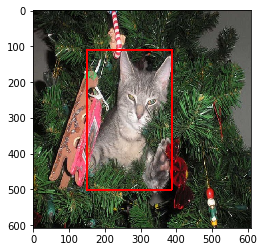

In [22]:
def sigmoid(x):
    return np.exp(x)/1+np.exp(x)

def draw_adjusted_anchor(img, idx_h, idx_w, idx_a, label_bbox):
    # box_adjustment.shape = [5,]
    
    center_y = (label_bbox[0]+idx_h)*GRID_SIZE
    center_x = (label_bbox[1]+idx_w)*GRID_SIZE
    
    height = label_bbox[2] * ANCHORS_NORMALIZED[idx_a,0] * IMG_H
    width = label_bbox[3] * ANCHORS_NORMALIZED[idx_a,1] * IMG_W
     
    left = int(center_x - width/2)
    top = int(center_y - height/2)
    right = int(left + width)
    bottom = int(top + height)

    img = cv2.rectangle(img, (left, top), (right, bottom), color=(255, 0, 0), thickness=3)
    
    return img
    
def draw_adjusted_anchors(img, label, data='gt'):
    # unnormalize image
    img = (img * 255).astype(np.uint8)
    
    for idx_h in range(GRID_H):
        for idx_w in range(GRID_W):
            for idx_a in range(NUM_ANCHORS):
                if label[idx_h, idx_w, idx_a, 5] > 0.:
                    bbox = label[idx_h, idx_w, idx_a, :4]
                    if data == 'pred':
                        bbox[0:2] = sigmoid(bbox[0:2])  # to keep offsets in interval [0,1]
                        bbox[2:4] = np.exp(bbox[2:4])  # to keep width and height to be positive
                    
                    img = draw_adjusted_anchor(img, idx_h, idx_w, idx_a, bbox)
    
    return img

def debug():
    tf.reset_default_graph()
    
    # check input fn return values
    imgs, labels = input_fn_train(DATA_TRAIN)
    
    # run session
    with tf.Session() as sess:
        i, l = sess.run([imgs, labels])

    # extract image and target
    idx_in_batch = 0
    img = i['img'][idx_in_batch]
    label = l[idx_in_batch]
    
    # plot
    img = draw_adjusted_anchors(img, label)
    plt.imshow(img)
    plt.show()
    
if DEBUG:
    debug()

## Model

In [23]:
# get feature columns
feature_columns = get_feature_columns()

# training configuration
run_config = tf.estimator.RunConfig().replace(keep_checkpoint_max=1, save_summary_steps=10)

# define model
model = tf.estimator.Estimator(
    model_fn=model_fn,
    params={
        'feature_columns': feature_columns,
        'num_anchors': ANCHORS.shape[0],
        'num_objects': NUM_OBJECTS
    },
    model_dir=MODEL_DIR,
    config=run_config
)

INFO:tensorflow:Using config: {'_evaluation_master': '', '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_task_id': 0, '_save_checkpoints_secs': 600, '_master': '', '_tf_random_seed': None, '_task_type': 'worker', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fda2c047a20>, '_model_dir': 'model', '_service': None, '_save_summary_steps': 10, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_keep_checkpoint_max': 1}


## Train

In [24]:
model.train(input_fn=lambda: input_fn_train(DATA_TRAIN), steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 501 into model/model.ckpt.
INFO:tensorflow:step = 501, loss = 11.531402
INFO:tensorflow:Saving checkpoints for 600 into model/model.ckpt.
INFO:tensorflow:Loss for final step: 8.417696.


## Predict

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


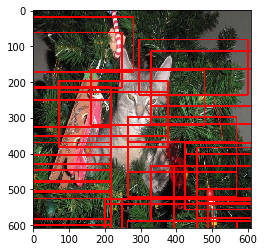

In [28]:
predictions = model.predict(input_fn=lambda: input_fn_predict(DATA_TRAIN))

idx = 13
iteration = 0
for p in predictions:
    i, p = p['imgs'], p['predictions']
    if iteration == idx:
        break
    iteration += 1

img = draw_adjusted_anchors(i, p, 'pred')
plt.imshow(img)
plt.show()

In [10]:
# tf.reset_default_graph()
# output = tf.random_normal([BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+20])
# b, p, c = get_predictions(output)

# with tf.Session() as sess:
#     b, p, c = sess.run([b, p, c])

In [11]:
# tf.reset_default_graph()
# f, l = input_fn_train(DATA_TRAIN)

# with tf.Session() as sess:
#     f, l = sess.run([f,l])

# idx_in_batch = 0
# l = l['targets'][idx_in_batch]

# plt.imshow(f['img'][0,:,:,:])
# for idx_object in range(l.shape[0]):
#     plt.scatter((l[idx_object,1]-l[idx_object,3]/2)*IMG_W, (l[idx_object,0]-l[idx_object,2]/2)*IMG_H, color='w')
#     plt.scatter((l[idx_object,1]-l[idx_object,3]/2)*IMG_W, (l[idx_object,0]+l[idx_object,2]/2)*IMG_H, color='w')
#     plt.scatter((l[idx_object,1]+l[idx_object,3]/2)*IMG_W, (l[idx_object,0]-l[idx_object,2]/2)*IMG_H, color='w')
#     plt.scatter((l[idx_object,1]+l[idx_object,3]/2)*IMG_W, (l[idx_object,0]+l[idx_object,2]/2)*IMG_H, color='w')
# plt.show()